In [18]:
!pip install git+https://github.com/ultralytics/ultralytics.git@main

ValueError: filedescriptor out of range in select()

In [19]:
from torch.utils.data import Dataset, DataLoader
import cv2
import os
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tifffile


# Создание датасета

In [20]:
#Добавить обработку MS фоток

class MyDataset(Dataset):
    def __init__(self, path, mode='rgb'):
        self.path = path
        self.video_output_path = f'{path}/{path.split("/")[-1]}.txt'
        self.frames_path = f'frames_{mode}'
        self.mode = mode
    
    def __len__(self):
        _, _, files = next(os.walk(f'{self.path}/{self.frames_path}'))
        return len(files)
        
    def __getitem__(self, idx):
        image_path=f'{self.path}/{self.frames_path}/{idx:04}.{"png" if self.mode == "rgb" else "tif"}'
        image_output_path=f'{self.path}/frames_output/{idx:04}.txt'
        video_output_path=f'{self.video_output_path}'
        #В image содержится фотография
        #В objects содержится список объектов с местоположением,уникальным номером
        # и классом для каждого из объекта
        #В image_output содержится массив с подсчитанным количеством объектов каждого класса
        sample = {'image':[], 'objects':[], 'image_output':[]}

        with open(image_output_path) as output_file:
            sample['image_output']=list(map(int, output_file.readlines()))

        objects_data = []
        start = False
        with open(video_output_path) as video_output_file:
            row = list(map(float, video_output_file.readline().split(', ')))
            for row in video_output_file.readlines():
                row = list(map(float, row.split(', ')))
                if row[0] != idx and start:
                    break
                if row[0] == idx:
                    start = True
                    objects_data.append(row[1:])
        
        sample['objects'] = objects_data
        
        im = Image.open(image_path)
        image = np.array(im)
        image = cv2.imread(image_path)
        sample['image'] = image

        return sample

# Обработка данных

In [21]:

    
# Путь к директории с кадрами
directory = '/kaggle/input/cifrovoyprorivtrash/video0'

dataset = MyDataset(directory)

# Функция для преобразования относительных координат в абсолютные
def convert_relative_to_absolute(relative_coord, image_size):
    x_center, y_center, box_width, box_height = relative_coord
    image_width, image_height = image_size
    x_abs = int((x_center - box_width / 2) * image_width)
    y_abs = int((y_center - box_height / 2) * image_height)
    w_abs = int(box_width * image_width)
    h_abs = int(box_height * image_height)
    return x_abs, y_abs, w_abs, h_abs

# Функция для рисования bounding box на кадре
def draw_frame_with_bounding_boxes(frame, frame_data, image_size):
    for current_frame in frame_data:
        object_id, label, x, y, w, h = current_frame
        x_abs, y_abs, w_abs, h_abs = convert_relative_to_absolute((x, y, w, h), image_size)
        x_right = x_abs + w_abs
        y_bottom = y_abs + h_abs
        frame = cv2.rectangle(frame, (x_abs, y_abs), (x_right, y_bottom), (255, 0, 0), 2)
        frame = cv2.putText(frame, f"{label} {object_id}", (x_abs, y_abs), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.show()

    


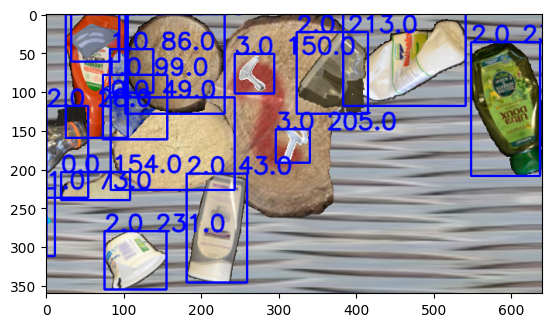

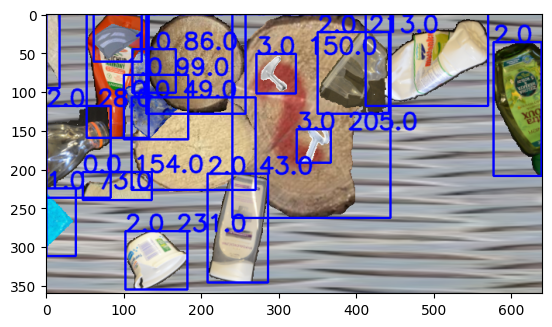

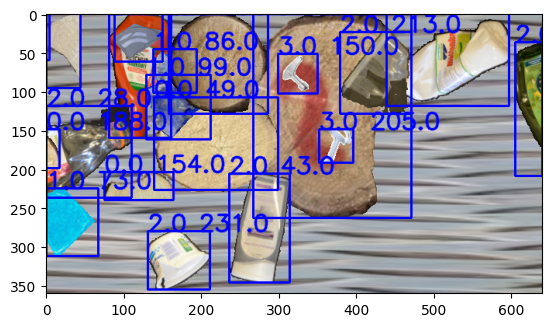

In [22]:
for idx in range(3):
    draw_frame_with_bounding_boxes(dataset[idx]['image'], dataset[idx]['objects'], dataset[idx]['image'].shape[0:2][::-1])

In [23]:
def processed_images(dataset, output_directory):
    os.makedirs(output_directory, exist_ok=True)

    # Сохранение обработанных кадров
    for idx in range(len(dataset)):  # Обработка первых трех кадров
        frame = dataset[idx]
        draw_frame_with_bounding_boxes(frame['image'], frame['objects'], frame['image'].shape[0:2][::-1])

        # Сохранение обработанных кадров
        processed_frame_path = os.path.join(output_directory, f"{idx:04d}.png")
        cv2.imwrite(processed_frame_path, frame['image'])

    

Создание видео

In [24]:
def make_video(dataset, output_video_path):
    # Создание объекта VideoWriter
    frame = dataset[0]['image']
    height, width, layers = frame.shape
    video = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), 30, (width, height))

    # Добавление кадров в видео
    for idx in range(len(dataset)):
        video.write(dataset[idx]['image'])

    # Закрытие видео
    video.release()

    print(f"Видео сохранено в {output_video_path}")

In [ ]:
make_video(dataset, '/kaggle/working/output_video.mp4')

# Создание тренировочного датасета

In [25]:
def get_frames_for_train(datasets):
    frames = dict()
    lengts = sum([len(x) for x in datasets])
    for dataset in datasets:
        for i in range(len(dataset)):
            objects = []
            for j in dataset[i]['objects']:
                objects.append([int(j[1]), *j[2:]])
            frames[f'{dataset.path}/frames_rgb/{i:04}.png'] = objects
    return frames

In [26]:
dataset1 = MyDataset('/kaggle/input/cifrovoyprorivtrash/video0')
dataset2 = MyDataset('/kaggle/input/cifrovoyprorivtrash/video1')
dataset3 = MyDataset('/kaggle/input/cifrovoyprorivtrash/video2')

In [27]:
frames = get_frames_for_train([dataset1, dataset2, dataset3])

In [28]:
frames

{'/kaggle/input/cifrovoyprorivtrash/video0/frames_rgb/0000.png': [[2,
   0.1016,
   0.225,
   0.125,
   0.4444],
  [2, 0.043, 0.4972, 0.0859, 0.3278],
  [2, 0.7234, 0.1694, 0.2469, 0.3333],
  [2, 0.3438, 0.7667, 0.1219, 0.3889],
  [0, 0.2547, 0.4694, 0.25, 0.3333],
  [1, 0.0086, 0.7472, 0.0172, 0.2444],
  [1, 0.1734, 0.2056, 0.0875, 0.1556],
  [1, 0.1797, 0.3361, 0.1312, 0.2333],
  [3, 0.4203, 0.2167, 0.0812, 0.1444],
  [0, 0.1, 0.6194, 0.1406, 0.1],
  [0, 0.2594, 0.1806, 0.2, 0.3556],
  [3, 0.4969, 0.475, 0.0688, 0.1222],
  [2, 0.5766, 0.2139, 0.1438, 0.2944],
  [1, 0.1, 0.0889, 0.0969, 0.1722],
  [2, 0.1797, 0.8861, 0.125, 0.2111],
  [2, 0.9281, 0.3417, 0.1406, 0.4778]],
 '/kaggle/input/cifrovoyprorivtrash/video0/frames_rgb/0001.png': [[0,
   0.5344,
   0.3667,
   0.3188,
   0.7278],
  [2, 0.1453, 0.225, 0.125, 0.4444],
  [2, 0.0648, 0.4972, 0.1297, 0.3278],
  [2, 0.7672, 0.1694, 0.2469, 0.3333],
  [2, 0.3875, 0.7667, 0.1219, 0.3889],
  [0, 0.2984, 0.4694, 0.25, 0.3333],
  [1, 0.0305

In [32]:
def make_yaml(path_to_end):
    with open(f'{path_to_end}/data.yaml', 'a') as yaml:
        yaml.write('train: ../train/images\n')
        yaml.write('val: ../valid/images\n')
        yaml.write('test: ../test/images\n')
        yaml.write('nc: 4\n')
        yaml.write('name: [wood, glass, plastic, metal]\n')
        
        yaml.write('''
lr0: 0.007  # initial learning rate (i.e. SGD=1E-2, Adam=1E-3)
lrf: 0.000001  # final learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.05  # warmup initial bias lr
box: 4.5  # 7.5 box loss gain
cls: 0.5  # cls loss gain (scale with pixels)
dfl: 1.5  # 1.5 dfl loss gain
pose: 12.0  # pose loss gain
kobj: 1.0  # keypoint obj loss gain
label_smoothing: 0.0  # label smoothing (fraction)
nbs: 64  # nominal batch size
hsv_h: 0.015  # image HSV-Hue augmentation (fraction)
hsv_s: 0.4  # image HSV-Saturation augmentation (fraction)
hsv_v: 0.4  # image HSV-Value augmentation (fraction)
degrees: 0.0  # image rotation (+/- deg)
translate: 0.1  # image translation (+/- fraction)
scale: 0.2  # image scale (+/- gain)
shear: 0.2  # image shear (+/- deg) from -0.5 to 0.5
perspective: 0.1  # image perspective (+/- fraction), range 0-0.001
flipud: 0.3  # image flip up-down (probability)
fliplr: 0.5  # image flip left-right (probability)
mosaic: 0.3  # image mosaic (probability)
mixup: 0.42  # image mixup (probability)
        ''')

In [33]:
def make_dataset(frames, path_to_end):
    os.popen(f'mkdir {path_to_end}/train')
    os.popen(f'mkdir {path_to_end}/valid')
    os.popen(f'mkdir {path_to_end}/test')
    while not os.path.exists(f'{path_to_end}/test'):
        pass
    make_yaml(path_to_end)
    name = 0
    for path, data in frames.items():
        
        os.popen(f'mkdir {path_to_end}/test/images')
        os.popen(f'mkdir {path_to_end}/test/labels')
        while not os.path.exists(f'{path_to_end}/test/labels'):
            pass
        os.popen(f'mkdir {path_to_end}/valid/images')
        os.popen(f'mkdir {path_to_end}/valid/labels')
        while not os.path.exists(f'{path_to_end}/valid/labels'):
            pass
        os.popen(f'mkdir {path_to_end}/train/images')
        os.popen(f'mkdir {path_to_end}/train/labels')
        while not os.path.exists(f'{path_to_end}/train/labels'):
            pass
        
#         print(path)
        #train
        if name < len(frames) * 0.75:
            output_string = '\n'.join([' '.join(list(map(str, obj))) for obj in data])
            os.popen(f'cp {path} {path_to_end}/train/images/{name:04}.png')
            with open(f'{path_to_end}/train/labels/{name:04}.txt', 'a') as file:
                file.write(output_string)
        #val
        elif len(frames) * 0.75 <= name <  len(frames) * 0.95:
            output_string = '\n'.join([' '.join(list(map(str, obj))) for obj in data])
            os.popen(f'cp {path} {path_to_end}/valid/images/{name:04}.png')
            with open(f'{path_to_end}/valid/labels/{name:04}.txt', 'a') as file:
                file.write(output_string)
        #test
        else:
            output_string = '\n'.join([' '.join(list(map(str, obj))) for obj in data])
            os.popen(f'cp {path} {path_to_end}/test/images/{name:04}.png')
            with open(f'{path_to_end}/test/labels/{name:04}.txt', 'a') as file:
                file.write(output_string)
        name += 1

In [31]:
!rm -rf /kaggle/working/

ValueError: filedescriptor out of range in select()

In [34]:
make_dataset(frames, '/kaggle/working')

# Обучение модели

In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8x.pt")
model.train(data='/kaggle/working/data.yaml', epochs=40)

Ultralytics YOLOv8.0.202 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/kaggle/working/data.yaml, epochs=40, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=Fa

In [ ]:
pred = model(dataset[122]['image'])

In [ ]:
pred = pred[0].boxes.data.tolist()
pred

In [ ]:
def draw_predict(predict, image):
    colors = {0:(255, 0, 0), 1:(0, 255, 0), 2:(0, 0, 255), 3:(0, 0, 0)}
    for i in pred:
        x1, y1, x2, y2, score, label = i
        image = cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), colors[int(label)], 2)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

def count_classes(predict):
    classes_c = dict()
    for obj in predict:
        if int(obj[-1]) not in classes_c.keys():
            classes_c[int(obj[-1])] = 1
        else:
            classes_c[int(obj[-1])] += 1
            
    return classes_c

In [ ]:
pred = model(dataset[203]['image'])[0].boxes.data.tolist()

In [ ]:
draw_predict(pred, dataset[203]['image'])
count_classes(pred).values(), dataset[203]['image_output']

In [ ]:
model.export(format="saved_model")